In [ ]:
!pip install six
#from six import string_types as string_classes


In [ ]:
!pip install pytorch-lightning --upgrade
# from pytorch_lightning.utilities import rank_zero_only


Install all the requirements

In [ ]:
#@title Installation
!git clone https://github.com/CompVis/latent-diffusion.git
!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops

import sys
sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan

fatal: destination path 'latent-diffusion' already exists and is not an empty directory.
fatal: destination path 'taming-transformers' already exists and is not an empty directory.
Obtaining file:///content/drive/MyDrive/atdl_assignment2/taming-transformers
  Preparing metadata (setup.py) ... done
  Attempting uninstall: taming-transformers
    Found existing installation: taming-transformers 0.0.1
    Uninstalling taming-transformers-0.0.1:
      Successfully uninstalled taming-transformers-0.0.1
  Running setup.py develop for taming-transformers


In [ ]:
#@title Download
%cd latent-diffusion/

!mkdir -p models/ldm/churches/
# in churches
#!wget -O models/ldm/cin256-v2/model.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt

/content/drive/MyDrive/atdl_assignment2/latent-diffusion


In [ ]:
%cd /content/drive/MyDrive/atdl_assignment2/latent-diffusion/models/ldm/churches

/content/drive/MyDrive/atdl_assignment2/latent-diffusion/models/ldm/churches


Let's also check what type of GPU we've got.

In [ ]:
!nvidia-smi

Mon Oct 21 20:16:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              48W / 400W |   8081MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

Load it.

In [ ]:
%cd /content/drive/MyDrive/atdl_assignment2/latent-diffusion/

/content/drive/MyDrive/atdl_assignment2/latent-diffusion


In [ ]:
#@title loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt)#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    model.eval()
    return model


def get_model():
  # Insert own .yaml file
    config = OmegaConf.load("/content/drive/MyDrive/atdl_assignment2/latent-diffusion/configs/latent-diffusion/lsun_churches-ldm-kl-4.yaml")
    #Insert owm .ckpt file
    model = load_model_from_config(config, "/content/drive/MyDrive/atdl_assignment2/latent-diffusion/models/ldm/churches/models.ckpt")
    return model

In [ ]:
from ldm.models.diffusion.ddim import DDIMSampler

model = get_model()
sampler = DDIMSampler(model)

Loading model from /content/drive/MyDrive/atdl_assignment2/latent-diffusion/models/ldm/churches/models.ckpt


<ipython-input-102-bd439c36a68b>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pl_sd = torch.load(ckpt)#, map_location="cpu")


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 47.24 M params.
Keeping EMAs of 184.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Training LatentDiffusion as an unconditional model.


In [ ]:
import numpy as np
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid
import torch
import matplotlib.pyplot as plt

n_samples = 5  # Total number of samples to generate

ddim_steps = 500
ddim_eta = 0.0

all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        # Generate samples without conditioning
        samples_ddim, _ = sampler.sample(S=ddim_steps,
                                         conditioning=None,
                                         batch_size=n_samples,
                                         shape=[3, 128, 128],
                                         verbose=False,
                                         eta=ddim_eta)

        x_samples_ddim = model.decode_first_stage(samples_ddim)
        x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0,
                                     min=0.0, max=1.0)
        all_samples.append(x_samples_ddim)

# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=6)  # Adjust nrow as needed

# Also save individual images
for i, sample in enumerate(all_samples[0]):
    img = sample.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis('off')
    plt.savefig(f'sample_{i+1}.png', bbox_inches='tight', pad_inches=0.1)
    plt.close()

print(f"Saved {n_samples} individual images as 'sample_1.png', 'sample_2.png', etc.")


Data shape for DDIM sampling is (5, 3, 128, 128), eta 0.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:11<00:00, 42.87it/s]


Image saved as 'generated_samples.png'
Saved 5 individual images as 'sample_1.png', 'sample_2.png', etc.


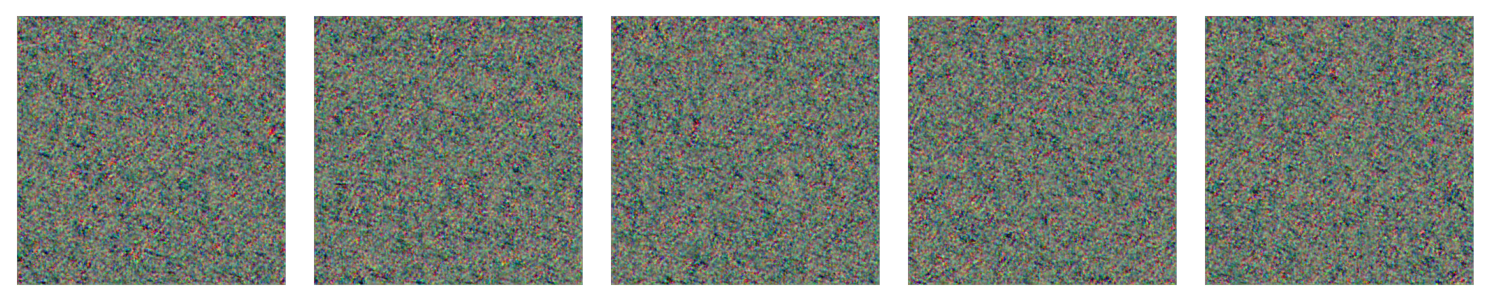

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


# Create a figure and a gridspec layout
fig = plt.figure(figsize=(15, 5))  # Adjust figure size as needed
gs = gridspec.GridSpec(1, 5)  # 1 row, 5 columns

# Iterate through the sample images and display them in the grid
for i in range(5):
  ax = fig.add_subplot(gs[i])
  img = plt.imread(f"/content/drive/MyDrive/atdl_assignment2/latent-diffusion/sample_{i+1}.png")
  ax.imshow(img)
  ax.axis('off')  # Turn off axis ticks and labels

plt.tight_layout()
plt.savefig('grid_plot.png')  # Save the grid plot
plt.show()

# FID

In [ ]:
%cd /content/drive/MyDrive/atdl_assignment2

/content/drive/MyDrive/atdl_assignment2


In [ ]:
#!git clone https://github.com/fyu/lsun.git
%cd /content/drive/MyDrive/atdl_assignment2/lsun
!python3 download.py -c church_outdoor

/content/drive/MyDrive/atdl_assignment2/lsun
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2335M  100 2335M    0     0  37.4M      0  0:01:02  0:01:02 --:--:-- 39.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5817k  100 5817k    0     0  6766k      0 --:--:-- --:--:-- --:--:-- 6764k


In [ ]:
!pip install lmdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.9 MB/s eta 0:00:00


In [ ]:
!unzip /content/drive/MyDrive/atdl_assignment2/lsun/church_outdoor_train_lmdb.zip

Archive:  /content/drive/MyDrive/atdl_assignment2/lsun/church_outdoor_train_lmdb.zip
   creating: church_outdoor_train_lmdb/
  inflating: church_outdoor_train_lmdb/lock.mdb  
  inflating: church_outdoor_train_lmdb/data.mdb  


In [ ]:
import os
import lmdb
import io
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as transforms

# Set up the transform
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
])

# Input and output directories
input_dir = "/content/drive/MyDrive/atdl_assignment2/lsun/church_outdoor_train_lmdb"
output_dir = "real_samples_100"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Open the LMDB environment
env = lmdb.open(input_dir, readonly=True, lock=False)

# Start a new read transaction
with env.begin(write=False) as txn:
    # Iterate through images
    cursor = txn.cursor()
    for idx, (key, value) in enumerate(cursor):
        # Process only 100 images
        if idx >= 100:
            break

        # Skip the length key
        if key != b'length':
            # Open the image
            img = Image.open(io.BytesIO(value))

            # Convert to RGB if necessary
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # Apply preprocessing
            img_tensor = preprocess(img)

            # Save the processed image
            output_path = os.path.join(output_dir, f"church_{idx:05d}.png")
            transforms.ToPILImage()(img_tensor).save(output_path)

        if idx % 10 == 0:
            print(f"Processed {idx} images")

# Close the environment
env.close()

print(f"Processed 100 images saved to {output_dir}")

Processed 0 images
Processed 10 images
Processed 20 images
Processed 30 images
Processed 40 images
Processed 50 images
Processed 60 images
Processed 70 images
Processed 80 images
Processed 90 images
Processed 100 images saved to real_samples_100


In [ ]:
import torch
import numpy as np
from PIL import Image
import os
import gc

# Adjustable parameters
n_samples = 100
ddim_steps = 500  # Reduced from 500
ddim_eta = 1.0
image_size = 128  # Reduced from 256
unconditional_guidance_scale = 1.0

def clear_cuda_cache():
    torch.cuda.empty_cache()
    gc.collect()

@torch.no_grad()
def generate_and_save_sample(index):
    with model.ema_scope():
        print(f"Rendering sample {index + 1} in {ddim_steps} steps.")

        samples_ddim, _ = sampler.sample(S=ddim_steps,
                                         conditioning=None,
                                         batch_size=1,
                                         shape=[3, image_size, image_size],
                                         verbose=False,
                                         unconditional_guidance_scale=unconditional_guidance_scale,
                                         unconditional_conditioning=None,
                                         eta=ddim_eta)

        x_sample = model.decode_first_stage(samples_ddim)
        x_sample = torch.clamp((x_sample + 1.0) / 2.0, min=0.0, max=1.0)

        # Convert to numpy array and prepare for saving
        sample_np = (x_sample.squeeze().permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

        # Save the image
        img = Image.fromarray(sample_np)
        img.save(f"generated_samples_100/sample_{index:05d}.png")
        print(f"Saved sample_{index:05d}.png")

        del samples_ddim, x_sample, sample_np, img
        clear_cuda_cache()

# Ensure the model is in evaluation mode
model.eval()

# Create directory for generated samples
os.makedirs("generated_samples_100", exist_ok=True)

# Generate and save samples
for i in range(n_samples):
    clear_cuda_cache()
    generate_and_save_sample(i)
    if i % 10 == 0:
        print(f"Generated {i+1} samples")

print("All samples generated and saved.")

Rendering sample 1 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 74.89it/s]


Saved sample_00000.png
Generated 1 samples
Rendering sample 2 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.50it/s]


Saved sample_00001.png
Rendering sample 3 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.59it/s]


Saved sample_00002.png
Rendering sample 4 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.41it/s]


Saved sample_00003.png
Rendering sample 5 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.30it/s]


Saved sample_00004.png
Rendering sample 6 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.79it/s]


Saved sample_00005.png
Rendering sample 7 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.51it/s]


Saved sample_00006.png
Rendering sample 8 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.45it/s]


Saved sample_00007.png
Rendering sample 9 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.80it/s]


Saved sample_00008.png
Rendering sample 10 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.48it/s]


Saved sample_00009.png
Rendering sample 11 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.89it/s]


Saved sample_00010.png
Generated 11 samples
Rendering sample 12 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.52it/s]


Saved sample_00011.png
Rendering sample 13 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.99it/s]


Saved sample_00012.png
Rendering sample 14 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.46it/s]


Saved sample_00013.png
Rendering sample 15 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.27it/s]


Saved sample_00014.png
Rendering sample 16 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.22it/s]


Saved sample_00015.png
Rendering sample 17 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.45it/s]


Saved sample_00016.png
Rendering sample 18 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.37it/s]


Saved sample_00017.png
Rendering sample 19 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.80it/s]


Saved sample_00018.png
Rendering sample 20 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.59it/s]


Saved sample_00019.png
Rendering sample 21 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.49it/s]


Saved sample_00020.png
Generated 21 samples
Rendering sample 22 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.21it/s]


Saved sample_00021.png
Rendering sample 23 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.92it/s]


Saved sample_00022.png
Rendering sample 24 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.45it/s]


Saved sample_00023.png
Rendering sample 25 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.74it/s]


Saved sample_00024.png
Rendering sample 26 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.28it/s]


Saved sample_00025.png
Rendering sample 27 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.37it/s]


Saved sample_00026.png
Rendering sample 28 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.38it/s]


Saved sample_00027.png
Rendering sample 29 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.45it/s]


Saved sample_00028.png
Rendering sample 30 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.51it/s]


Saved sample_00029.png
Rendering sample 31 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.18it/s]


Saved sample_00030.png
Generated 31 samples
Rendering sample 32 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.58it/s]


Saved sample_00031.png
Rendering sample 33 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.51it/s]


Saved sample_00032.png
Rendering sample 34 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.59it/s]


Saved sample_00033.png
Rendering sample 35 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.20it/s]


Saved sample_00034.png
Rendering sample 36 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.53it/s]


Saved sample_00035.png
Rendering sample 37 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.94it/s]


Saved sample_00036.png
Rendering sample 38 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.88it/s]


Saved sample_00037.png
Rendering sample 39 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.40it/s]


Saved sample_00038.png
Rendering sample 40 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.41it/s]


Saved sample_00039.png
Rendering sample 41 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.75it/s]


Saved sample_00040.png
Generated 41 samples
Rendering sample 42 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.94it/s]


Saved sample_00041.png
Rendering sample 43 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.51it/s]


Saved sample_00042.png
Rendering sample 44 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.08it/s]


Saved sample_00043.png
Rendering sample 45 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.66it/s]


Saved sample_00044.png
Rendering sample 46 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.33it/s]


Saved sample_00045.png
Rendering sample 47 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.13it/s]


Saved sample_00046.png
Rendering sample 48 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.50it/s]


Saved sample_00047.png
Rendering sample 49 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.59it/s]


Saved sample_00048.png
Rendering sample 50 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.55it/s]


Saved sample_00049.png
Rendering sample 51 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.20it/s]


Saved sample_00050.png
Generated 51 samples
Rendering sample 52 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 74.88it/s]


Saved sample_00051.png
Rendering sample 53 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.38it/s]


Saved sample_00052.png
Rendering sample 54 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.12it/s]


Saved sample_00053.png
Rendering sample 55 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.16it/s]


Saved sample_00054.png
Rendering sample 56 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.15it/s]


Saved sample_00055.png
Rendering sample 57 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.02it/s]


Saved sample_00056.png
Rendering sample 58 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.04it/s]


Saved sample_00057.png
Rendering sample 59 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.39it/s]


Saved sample_00058.png
Rendering sample 60 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 74.79it/s]


Saved sample_00059.png
Rendering sample 61 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.45it/s]


Saved sample_00060.png
Generated 61 samples
Rendering sample 62 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.86it/s]


Saved sample_00061.png
Rendering sample 63 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.40it/s]


Saved sample_00062.png
Rendering sample 64 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.94it/s]


Saved sample_00063.png
Rendering sample 65 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.63it/s]


Saved sample_00064.png
Rendering sample 66 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.70it/s]


Saved sample_00065.png
Rendering sample 67 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.00it/s]


Saved sample_00066.png
Rendering sample 68 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.27it/s]


Saved sample_00067.png
Rendering sample 69 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.54it/s]


Saved sample_00068.png
Rendering sample 70 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.69it/s]


Saved sample_00069.png
Rendering sample 71 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.01it/s]


Saved sample_00070.png
Generated 71 samples
Rendering sample 72 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.74it/s]


Saved sample_00071.png
Rendering sample 73 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.34it/s]


Saved sample_00072.png
Rendering sample 74 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.95it/s]


Saved sample_00073.png
Rendering sample 75 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.78it/s]


Saved sample_00074.png
Rendering sample 76 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.03it/s]


Saved sample_00075.png
Rendering sample 77 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.47it/s]


Saved sample_00076.png
Rendering sample 78 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.88it/s]


Saved sample_00077.png
Rendering sample 79 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.50it/s]


Saved sample_00078.png
Rendering sample 80 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.33it/s]


Saved sample_00079.png
Rendering sample 81 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.87it/s]


Saved sample_00080.png
Generated 81 samples
Rendering sample 82 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.87it/s]


Saved sample_00081.png
Rendering sample 83 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.57it/s]


Saved sample_00082.png
Rendering sample 84 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.22it/s]


Saved sample_00083.png
Rendering sample 85 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.13it/s]


Saved sample_00084.png
Rendering sample 86 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.52it/s]


Saved sample_00085.png
Rendering sample 87 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.29it/s]


Saved sample_00086.png
Rendering sample 88 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.81it/s]


Saved sample_00087.png
Rendering sample 89 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.34it/s]


Saved sample_00088.png
Rendering sample 90 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.64it/s]


Saved sample_00089.png
Rendering sample 91 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.81it/s]


Saved sample_00090.png
Generated 91 samples
Rendering sample 92 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.06it/s]


Saved sample_00091.png
Rendering sample 93 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.52it/s]


Saved sample_00092.png
Rendering sample 94 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.04it/s]


Saved sample_00093.png
Rendering sample 95 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.46it/s]


Saved sample_00094.png
Rendering sample 96 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.93it/s]


Saved sample_00095.png
Rendering sample 97 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.64it/s]


Saved sample_00096.png
Rendering sample 98 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 75.22it/s]


Saved sample_00097.png
Rendering sample 99 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.54it/s]


Saved sample_00098.png
Rendering sample 100 in 500 steps.
Data shape for DDIM sampling is (1, 3, 128, 128), eta 1.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:06<00:00, 76.10it/s]


Saved sample_00099.png
All samples generated and saved.


In [ ]:
!pip install torch-fidelity

In [ ]:
from torch_fidelity import calculate_metrics

# Calculate both metrics at once
metrics = calculate_metrics(
    input1='/content/drive/MyDrive/atdl_assignment2/lsun/generated_samples_100',  # Directory with generated images
    input2='/content/drive/MyDrive/atdl_assignment2/lsun/real_samples_100',       # Directory with real images
    cuda=True,
    isc=True,     # Calculate Inception Score
    fid=True,     # Calculate FID
    batch_size=10,  # Adjust based on your GPU memory
    verbose=True
)

# Print results
print("\nMetrics:")
print(f"Inception Score: {metrics['inception_score_mean']} ± {metrics['inception_score_std']}")
print(f"FID Score: {metrics['frechet_inception_distance']}")

Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Looking for samples non-recursivelty in "/content/drive/MyDrive/atdl_assignment2/lsun/generated_samples_100" with extensions png,jpg,jpeg
Found 100 samples
/usr/local/lib/python3.10/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/content/drive/MyDrive/atdl_assignment2/lsun/real_samples_100" with extensions png,jpg,jpeg
Found 100 samples
Processing samples
Inception Score: 1.0852365396077706 ± 0.0159251722


Metrics:
Inception Score: 1.0852365396077706 ± 0.015925172230631758
FID Score: 457.43309936942387


Frechet Inception Distance: 457.43309936942387
